In [50]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from glob import glob
from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable)

In [6]:
POP_dir = '/scratch/DaanR/fields/pop_1deg_monthly/'
POP_files = sorted(glob(POP_dir+'t.x1_SAMOC_flux.160???.interp.nc'))
EEZ_ds = xr.open_dataset('EEZ.nc4')

In [7]:
filenames = { 'U': {'lon': [POP_files[0]],
                    'lat': [POP_files[0]],
                    'data':POP_files},
            'V' : {'lon': [POP_files[0]],
                    'lat': [POP_files[0]],
                    'data':POP_files}}

variables = {'U': 'UVEL',
             'V': 'VVEL',}

dimensions = {'U':{'time': 'Time', 'lat': 'u_lat', 'lon': 'u_lon'},
              'V': {'time': 'Time', 'lat': 'u_lat', 'lon': 'u_lon'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=False)
fieldset.U.set_scaling_factor(0.01)  #convert cm/s to m/s
fieldset.V.set_scaling_factor(0.01)
fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
fieldset.V.vmax = 10;  fieldset.V.vmin = -10;

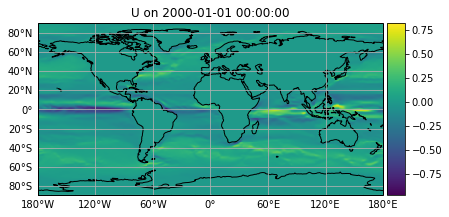

In [8]:
fieldset.U.show()

In [37]:
EEZ = EEZ_ds['EEZ'][2,:,:]
EEZ_lats = EEZ_ds['CenterLat'].data
EEZ_lons = EEZ_ds['CenterLong'].data

In [44]:
EEZ_field = Field(name="EEZ", data=EEZ.data, lon=EEZ_lons, lat=EEZ_lats, allow_time_extrapolation=True)
fieldset.add_field(EEZ_field)

In [45]:
class myParticle(JITParticle):
        EEZ = Variable('EEZ', dtype=np.int32, to_write=True)

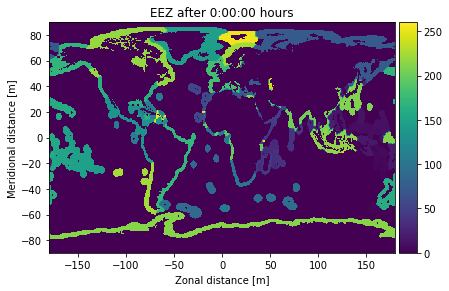

In [46]:
fieldset.EEZ.show()

In [49]:
def EEZ_sampler(particle, fieldset, time):
    particle.EEZ = fieldset.EEZ[time, 0., particle.lat, particle.lon]

def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [60]:
times = np.array([datetime(2003, 1, 1) - delta(days=x) for x in range(0,int(365*1),3)])
release_lon = np.array([3+180])
release_lat = np.array([52])
part_time = np.empty(shape=(0))
part_lats = np.empty(shape=(0))
part_lons = np.empty(shape=(0))
for i in range(len(times)):
    lons = np.append(part_lons, release_lon)
    lats = np.append(part_lats, release_lat)
    time = np.append(part_time, np.full(len(release_lon),times[i])) 

In [67]:
pset = ParticleSet.from_list(fieldset=fieldset, pclass=myParticle, lon=lons.tolist(), lat=lats.tolist(), 
                       time = time)

In [62]:
pfile = ParticleFile('pFileEEZ', pset, outputdt=delta(days=3))

In [63]:
kernels = pset.Kernel(AdvectionRK4) + EEZ_sampler  

In [ ]:
pset.execute(kernels, \
             runtime=delta(days=3285), \
             dt = delta(minutes=10), \
             output_file = pfile, \
             verbose_progress = True, \
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

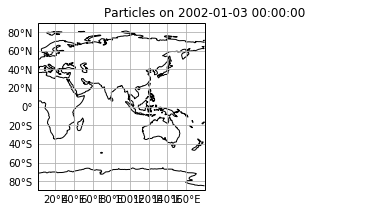

In [68]:
pset.show()